# Evaluation

The evaluation file use JupyterNotebook to visual the simulation and train result.

In [1]:
from settings import APP_CONFIG, UNREAL_CONFIG

CHECKPOINT_PATH = APP_CONFIG['checkpoint_path']
HISTORY_PATH = APP_CONFIG['training_history']
CSV_PATH = APP_CONFIG['preprocessed_csv_file']
NUM_OF_BEACONS = UNREAL_CONFIG['num_of_beacons']

## 1. Loss

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [16]:
def plot_loss(df):
    plt.figure(figsize=(20,5))
    plt.plot(df.training_loss)
    plt.plot(df.test_loss)
    plt.grid()
    plt.legend(labels=['training loss','test loss'], loc='upper left')

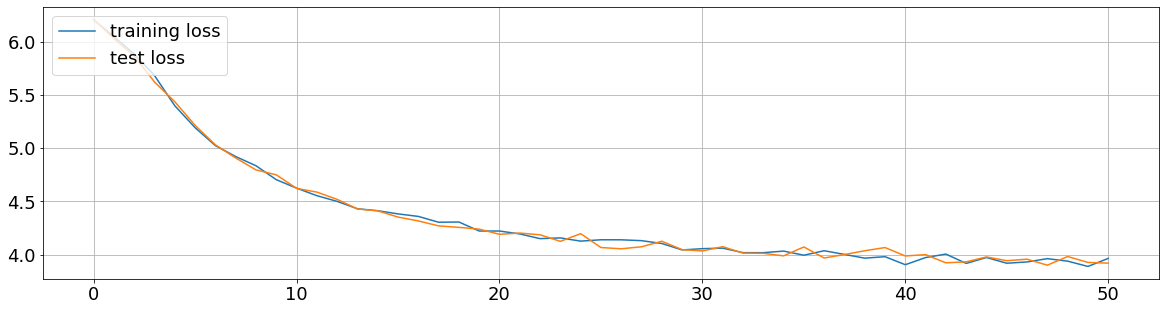

In [17]:
loss_df = pd.read_csv(HISTORY_PATH)
plot_loss(loss_df)

Load csv data to dataframe

In [5]:
import pandas as pd
df = pd.read_csv(CSV_PATH)
df.head()

,x,y,z,timestamp,Beacon1,Beacon2,Beacon3,Beacon4,Beacon5,Beacon6,...,Beacon13,Beacon14,Beacon15,Beacon16,Beacon17,Beacon18,Beacon19,Beacon20,Beacon21,Beacon22
0,709,86,114,2022.07.25-10.46.25,-100,-97,-92,-98,-90,-87,...,-94,-99,-100,-93,-100,-100,-100,-100,-90,-80
1,695,86,114,2022.07.25-10.46.25,-100,-98,-96,-100,-87,-87,...,-96,-98,-100,-93,-100,-100,-100,-100,-90,-80
2,668,89,118,2022.07.25-10.46.25,-96,-97,-92,-97,-90,-88,...,-96,-99,-91,-92,-100,-100,-93,-100,-90,-79
3,655,90,120,2022.07.25-10.46.25,-98,-95,-92,-98,-90,-88,...,-95,-93,-91,-96,-100,-100,-93,-100,-90,-80
4,630,95,126,2022.07.25-10.46.25,-96,-94,-92,-98,-90,-89,...,-95,-98,-91,-92,-100,-100,-93,-100,-90,-80


## 2. Load Trained Model

In [6]:
import tensorflow as tf
from nn.deepAR import create_model

model = create_model(dim_x=NUM_OF_BEACONS, dim_z=3)
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))

Restoring checkpoint from checkpoints/deepAR\ckpt-51


## 3. Visualize Prediction Result

### 3.1 Contruct Long Sequence Dataset

In [7]:
from preprocessing.dataset import DatasetGenerator

norm_df = df.drop(columns=['timestamp'])
norm_df = norm_df[-10000:]
mean, std = list(norm_df.mean()[:3]), list(norm_df.std()[:3])
norm_df = (norm_df - norm_df.mean())/(norm_df.std() + 1e-10)
columns = list(norm_df.columns)
seq_len = 3000
long_dg = DatasetGenerator(data=norm_df, input_width=seq_len, label_width=seq_len, 
                           shift=0, batch_size=1, columns=columns, input_columns=columns[3:], label_columns=columns[:3],  partition=(0.3,0.3,0.3))

In [8]:
import numpy as np

def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    ax = plt.figure(figsize=(20,9)).add_subplot(1, 1, 1)
    inputs, labels = data
    means, _ = model(inputs)
    mean = (means[batch_index, :] * df_std + df_mean) * 0.01
    label = (labels[batch_index, :] * df_std + df_mean) * 0.01
    ax.plot(-mean[warmup_step:, 0] + x_offset, mean[warmup_step:, 1] + y_offset, '-r', alpha=0.5)
    ax.plot(-label[warmup_step:,0] + x_offset, label[warmup_step:,1] + y_offset, '--g', alpha=0.5)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    # grid
    x_major_ticks = np.arange(0, 26, 5)
    x_minor_ticks = np.arange(0, 26, 1)
    y_major_ticks = np.arange(0, 12, 5)
    y_minor_ticks = np.arange(0, 12, 1)
    ax.set_xticks(x_major_ticks)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=0.5)
    plt.show()

### 3.2 Training-set Result

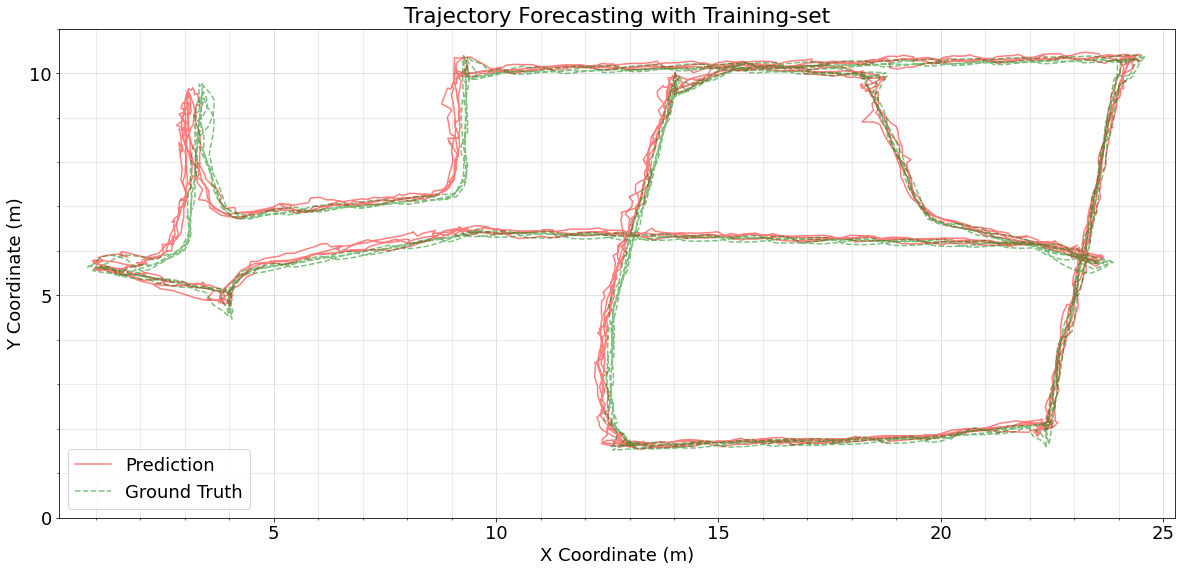

In [10]:
assert len(list(long_dg.train_ds)) > 0, "Data size is too small to contruct training-set, please try to collect more data and try again"
model_plot2D(model=model, data=next(iter(long_dg.train_ds)), title='Trajectory Forecasting with Training-set',batch_index=0, df_mean=mean, df_std = std, x_offset=11.5, y_offset=6)

### 3.3 Test-set Result

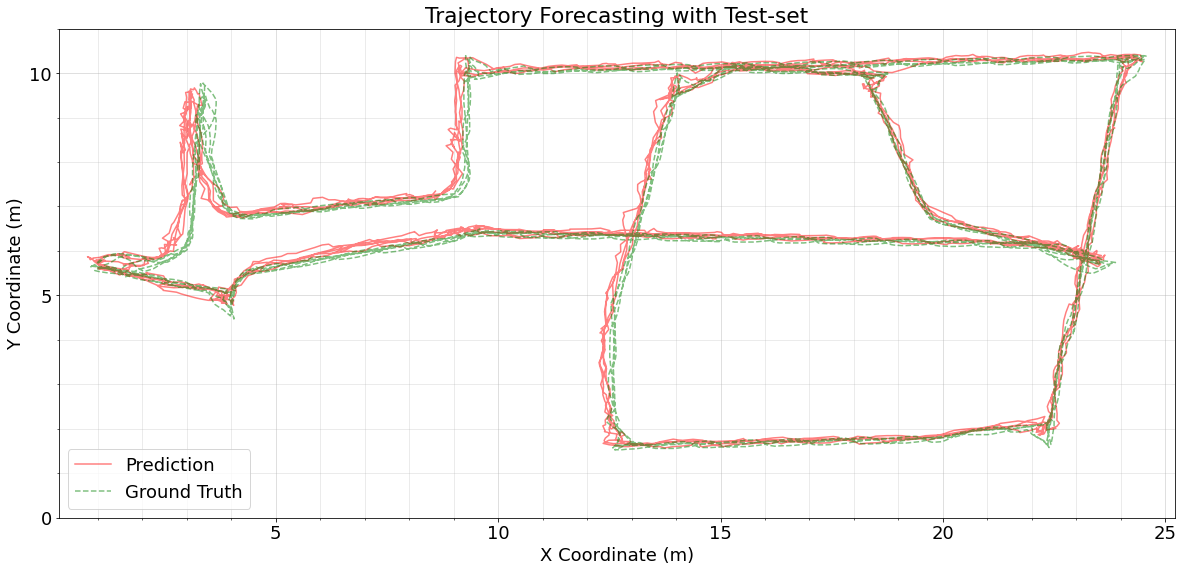

In [11]:
assert len(list(long_dg.test_ds)) > 0, "Data size is too small to contruct test-set, please try to collect more data and try again"
model_plot2D(model=model, data=next(iter(long_dg.test_ds)), title='Trajectory Forecasting with Test-set', batch_index=0, df_mean=mean, df_std = std, x_offset=11.5, y_offset=6)